## Clustering dei Pokémon tramite K-Means

In questo notebook viene implementata una procedura di **clustering non supervisionato** sul dataset ufficiale dei Pokémon, con l'obiettivo di **scoprire raggruppamenti latenti (cluster)** in base a caratteristiche combattive aggregate. Le caratteristiche combattive aggregate sono risultati essere semanticamente più significative rispetto alle statistiche "grezze".

### Metodologia adottata

1. **Preprocessing del dataset**:
   - Rimozione dei Pokémon in forma Mega (forme speciali non standard).
   - Eliminazione dei duplicati.
   - Costruzione di nuove feature aggregate per catturare le dimensioni principali del combattimento:
     - `OFF_FISICO` = Attacco + Velocità
     - `OFF_SPECIALE` = Attacco Speciale + Velocità
     - `TANK_FISICO` = HP + Difesa
     - `TANK_SPECIALE` = HP + Difesa Speciale

2. **Standardizzazione delle feature**:
   - Le feature vengono scalate tramite `StandardScaler` per garantire parità di contributo nelle distanze euclidee.

3. **Riduzione dimensionale opzionale**:
   - È possibile applicare una PCA per rappresentazioni visuali bidimensionali.

4. **Clustering con K-Means**:
   - Viene utilizzato l'algoritmo K-Means su un numero prefissato di cluster (`K_FINAL = 4`).
   - La scelta del numero di cluster è supportata da analisi grafiche (Elbow Method, Silhouette Score).

### Obiettivo

Il clustering mira a individuare **archetipi di Pokémon** basati su stili di combattimento (bilanciato/base, difensivo/tank, offensivo, elite/leggendario).
Questi cluster verranno successivamente utilizzati come **etichette pseudo-supervisionate** in modelli di classificazione per validare la qualità della segmentazione ottenuta.

In [1]:
#import delle librerie
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split

### 1. Caricamento del dataset

In [2]:
# IPER-PARAMETRO dell'algoritmo K MEANS PRINCIPALE
K_FINAL = 4  # Scelto in modo arbitrario in base ai grafici

# Carica il dataset Pokémon
df = pd.read_csv("risorse/Pokemon.csv")
#Eliminazione dei pokemon mega evoluti
#I pokemon mega evoluti vanno eliminati dal dataset
#Ci sarebbero anche altre forme che andrebbero eliminate a mano dal dataset
df = df[~df["Name"].str.contains("Mega", na=False)].drop_duplicates(subset="Name")

### 2. Creazione di nuove feature (di input)
I modelli supervisionati successivi sono addestrati utilizzando feature aggregate che sintetizzano i comportamenti offensivi e difensivi dei Pokémon.
Rispetto alle statistiche base (HP, Attack, Speed, Df, Sp. df, sp.Atk), queste variabili astratte risultano più informative per discriminare i ruoli tattici (Tank, Attaccante, Base, Elite/Leggendario), poiché integrano più dimensioni del profilo del Pokémon.
Empiricamente si è osservato un ottimo comportamento dei classificatori anche in presenza di traning set sbilanciati a dimostrare una buona qualità delle feature introdotte.

In [3]:
#Nuove feature su cui scegliamo di lavorare
df["OFF_FISICO"]    = df["Attack"] + df["Speed"]
df["OFF_SPECIALE"]  = df["Sp. Atk"] + df["Speed"]
df["TANK_FISICO"]   = df["HP"] + df["Defense"]
df["TANK_SPECIALE"] = df["HP"] + df["Sp. Def"]
features = ["OFF_FISICO", "OFF_SPECIALE", "TANK_FISICO", "TANK_SPECIALE"]

### 3. Divisione tra traning set e test set e, standardizzazione dei valori

In [4]:
# IMPORTANTE Separazione Train/Test
#In questo passo non possediamo la colonna target perché ci viene creata nel momento in cui
#effettuiamo il clustering con k means. Quindi ci dobbiamo accontentare di non utilizzare stratify.
#Sappiamo benissimo che la popolazione reale dei pokemon sia in realtà sbilanciata in base alle quattro classi per cui un test set che risulta essere sbilanciato è in realtà un buon surrogato degli esempi reali
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42, stratify=None)

# Standardizzazione solo sul training
# il k means è influenzato da scale diverse dei valori
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(df_train[features])
X_test_scaled = scaler.transform(df_test[features])

### 4. Curve di Elbow e Silhouette Plot solo sul training set


Analisi multipla per diversi k (solo su training):
k=2: Inertia = 1294.03, Silhouette = 0.4018
k=3: Inertia = 1006.82, Silhouette = 0.3570
k=4: Inertia = 841.85, Silhouette = 0.3396
k=5: Inertia = 754.36, Silhouette = 0.2652
k=6: Inertia = 687.23, Silhouette = 0.2376
k=7: Inertia = 631.40, Silhouette = 0.2411
k=8: Inertia = 586.79, Silhouette = 0.2235
k=9: Inertia = 548.74, Silhouette = 0.2189
k=10: Inertia = 511.18, Silhouette = 0.2350


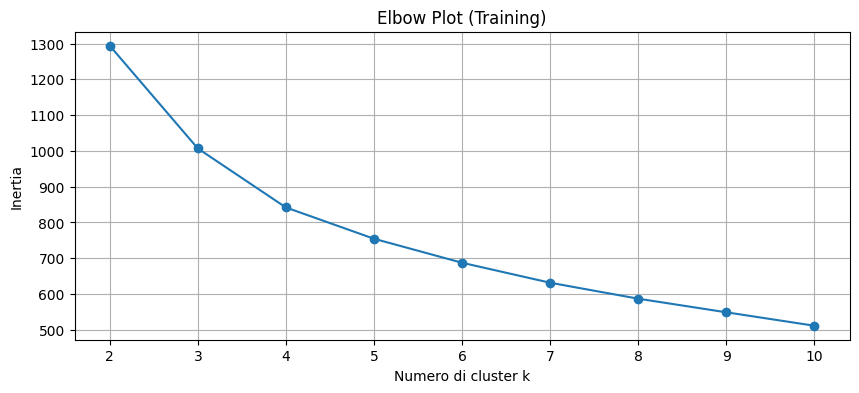

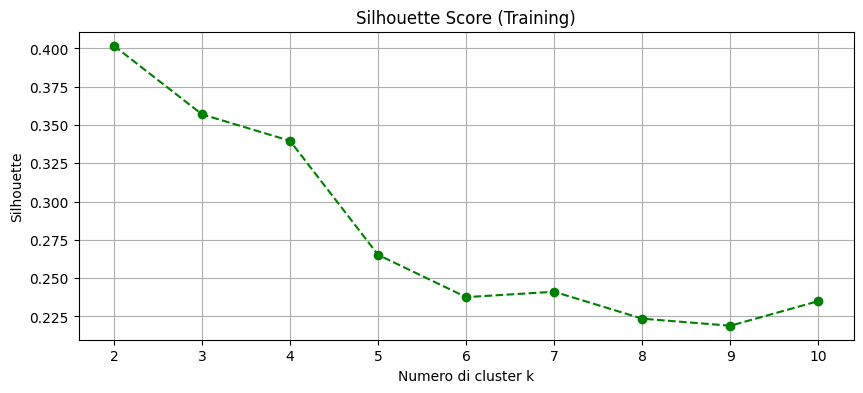

In [5]:
#Elbow e Silhouette Plot solo sul training set
ks = list(range(2, 11))
inertias, silhouettes = [], []
print("\nAnalisi multipla per diversi k (solo su training):")
for k in ks:
    km_tmp = KMeans(n_clusters=k, n_init=10, random_state=42)
    labels_tmp = km_tmp.fit_predict(X_train_scaled)
    inertia = km_tmp.inertia_
    silhouette = silhouette_score(X_train_scaled, labels_tmp)
    inertias.append(inertia)
    silhouettes.append(silhouette)
    print(f"k={k}: Inertia = {inertia:.2f}, Silhouette = {silhouette:.4f}")

# Plot separati
plt.figure(figsize=(10, 4))
plt.plot(ks, inertias, marker='o', label="Inertia")
plt.title("Elbow Plot (Training)")
plt.xlabel("Numero di cluster k"); plt.ylabel("Inertia"); plt.grid(True)
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(ks, silhouettes, marker='o', color='green', linestyle='--', label="Silhouette Score")
plt.title("Silhouette Score (Training)")
plt.xlabel("Numero di cluster k"); plt.ylabel("Silhouette"); plt.grid(True)
plt.show()

### 5. Clustering su traning set con K iperparametro scelto
Nel nostro caso, il numero di cluster k rappresenta un iper-parametro del modello K-Means, in quanto viene fissato manualmente prima dell'esecuzione dell'algoritmo e ne determina direttamente la granularità della segmentazione. I parametri veri e propri del modello, come le posizioni finali dei centroidi, vengono invece appresi automaticamente durante l'ottimizzazione iterativa

In [6]:
# Per notebook: visualizza direttamente il DataFrame in formato leggibile
from IPython.display import display

# Fit + predict
kmeans = KMeans(n_clusters=K_FINAL, n_init=10, random_state=42)
df_train["Cluster"] = kmeans.fit_predict(X_train_scaled)
df_test["Cluster"] = kmeans.predict(X_test_scaled)

# Distanze (sempre nello spazio scalato)
#Utili per fornire un altro metodo per classificare
distanze_train = kmeans.transform(X_train_scaled)
distanze_test = kmeans.transform(X_test_scaled)
for i in range(K_FINAL):
    df_train[f"dist_cluster_{i}"] = distanze_train[:, i]
    df_test[f"dist_cluster_{i}"] = distanze_test[:, i]

# Visualizzazione centroidi nello spazio originale (solo per interpretazione)
centroidi = scaler.inverse_transform(kmeans.cluster_centers_)
centroidi_df = pd.DataFrame(centroidi, columns=features)
centroidi_df["Cluster"] = range(K_FINAL)
centroidi_df["TOT"] = centroidi_df[features].sum(axis=1)
centroidi_df["OFF_MEDIA"] = (centroidi_df["OFF_FISICO"] + centroidi_df["OFF_SPECIALE"]) / 2
centroidi_df["TANK_MEDIA"] = (centroidi_df["TANK_FISICO"] + centroidi_df["TANK_SPECIALE"]) / 2
centroidi_df["Count"] = df_train["Cluster"].value_counts().sort_index().values

print("\nCentroidi dei cluster (valori reali):")
display(centroidi_df.round(1))

FEATURES = [f"dist_cluster_{i}" for i in range(K_FINAL)]
TARGET = "Cluster"

df_train_dist = df_train[FEATURES + [TARGET]].copy()
df_test_dist = df_test[FEATURES + [TARGET]].copy()
df_train_dist.to_csv("risorse/pokemon_train_con_distanze.csv", index=False)
df_test_dist.to_csv("risorse/pokemon_test_con_distanze.csv", index=False)
centroidi_df.to_csv("risorse/centroidi_etichettati.csv", index=False)


Centroidi dei cluster (valori reali):


,OFF_FISICO,OFF_SPECIALE,TANK_FISICO,TANK_SPECIALE,Cluster,TOT,OFF_MEDIA,TANK_MEDIA,Count
0,102.6,97.0,104.3,100.6,0,404.6,99.8,102.5,245
1,215.6,214.0,182.4,185.7,1,797.7,214.8,184.1,74
2,169.4,166.8,137.7,140.7,2,614.5,168.1,139.2,166
3,137.1,122.5,191.3,183.6,3,634.6,129.8,187.5,115


### 6. Mappatura cluster -> archetipi (supervisionato da esperto su dati)

In [7]:
#Mappatura archetipi
def etichetta_centroidi(centroidi_df):
    cluster_ids = centroidi_df["Cluster"].tolist()
    labels = {}
    elite = centroidi_df.sort_values("TOT", ascending=False).iloc[0]["Cluster"]
    labels[elite] = "Elite/Leggendario"
    rest = centroidi_df[~(centroidi_df["Cluster"] == elite)]
    if not rest.empty:
        att = rest.sort_values("OFF_MEDIA", ascending=False).iloc[0]["Cluster"]
        labels[att] = "Attaccante"
    else:
        att = None
    rest2 = centroidi_df[~(centroidi_df["Cluster"].isin([elite, att]))]
    if not rest2.empty:
        tank = rest2.sort_values("TANK_MEDIA", ascending=False).iloc[0]["Cluster"]
        labels[tank] = "Tank"
    labeled = set(labels.keys())
    for cid in cluster_ids:
        if cid not in labeled:
            labels[cid] = "Balanced"
    return labels

In questa fase viene attribuito un **significato semantico ai cluster** ottenuti dal K-Means, sulla base delle **medie dei vettori centroidi**. Tale operazione è resa possibile grazie all’interpretazione dell’esperto, che assegna un’etichetta descrittiva ai gruppi individuati dall’algoritmo.

Avendo scelto \(K = 4\), i cluster vengono etichettati come:
- **Bilanciati**
- **Attaccante**
- **Elite/Leggendario**
- **Tank**

Una successiva suddivisione più fine — ad esempio distinguendo tra *Attaccante Fisico* e *Attaccante Speciale*, oppure tra *Tank Difensivo* e *Tank Speciale* — può essere effettuata **senza rieseguire il K-Means**. È infatti sufficiente analizzare le feature associate al singolo Pokémon per attribuirgli il corretto **SubArchetipo**.

---

### Tabella Archetipi e SubArchetipi

| Cluster            | Archetipo           | Possibili SubArchetipi               |
|--------------------|---------------------|--------------------------------------|
| 0                  | Bilanciati          | —                                    |
| 1                  | Attaccante          | Attaccante Fisico, Attaccante Speciale |
| 2                  | Elite/Leggendario   | —                                    |
| 3                  | Tank                | Tank Difensivo, Tank Speciale        |


In [8]:
# Mappatura dei Cluster -> Archetipi (mappattura dell'esperto)
cluster_labels = etichetta_centroidi(centroidi_df)
df_train["Archetipo"] = df_train["Cluster"].map(cluster_labels)
df_test["Archetipo"] = df_test["Cluster"].map(cluster_labels)

# Sub-Archetipo solo per Attaccanti nel TRAIN SET
mask_att_train = df_train["Archetipo"] == "Attaccante"
df_train.loc[mask_att_train, "SubArchetipo"] = np.where(
    df_train.loc[mask_att_train, "OFF_FISICO"] > df_train.loc[mask_att_train, "OFF_SPECIALE"],
    "Attaccante Fisico",
    "Attaccante Speciale"
)

# Sub-Archetipo solo per Tank nel TRAIN SET
mask_tank_train = df_train["Archetipo"] == "Tank"
df_train.loc[mask_tank_train, "SubArchetipo"] = np.where(
    df_train.loc[mask_tank_train, "TANK_FISICO"] > df_train.loc[mask_tank_train, "TANK_SPECIALE"],
    "Tank Fisico",
    "Tank Speciale"
)

# Stessa cosa sul TEST SET
mask_att_test = df_test["Archetipo"] == "Attaccante"
df_test.loc[mask_att_test, "SubArchetipo"] = np.where(
    df_test.loc[mask_att_test, "OFF_FISICO"] > df_test.loc[mask_att_test, "OFF_SPECIALE"],
    "Attaccante Fisico",
    "Attaccante Speciale"
)

mask_tank_test = df_test["Archetipo"] == "Tank"
df_test.loc[mask_tank_test, "SubArchetipo"] = np.where(
    df_test.loc[mask_tank_test, "TANK_FISICO"] > df_test.loc[mask_tank_test, "TANK_SPECIALE"],
    "Tank Fisico",
    "Tank Speciale"
)

#Ricostruzione df completo per salvataggio finale del CSV traning + test
df_finale = pd.concat([df_train, df_test], axis=0)
# Salvataggio CSV finale -> molto utile per determinare quali pokemon sono stati raggruppati
df_finale[["Name", *features, "Archetipo", "SubArchetipo"]].to_csv("risorse/Pokemon_archetipi.csv", index=False)
print("✔️ File salvato: risorse/Pokemon_archetipi.csv")

✔️ File salvato: risorse/Pokemon_archetipi.csv


### 7. PCA e visualizzazione grafica della distribuzione dei dati nei cluster
La figura riporta la proiezione bidimensionale, ottenuta tramite **PCA**, dei dati di training e test nello spazio dei primi due componenti principali.

- I **cerchi pieni** rappresentano i dati del training, colorati in base al cluster di appartenenza.
- I **triangoli** indicano i dati del test, anch’essi assegnati ai cluster secondo il modello K-Means addestrato sul training.
- I **simboli “X” neri** rappresentano i **centroidi dei cluster**, proiettati nello spazio PCA.
- Le etichette numeriche poste sui centroidi indicano l’indice del cluster (\(0 \ldots K-1\)).

La PCA non è stata utilizzata per il clustering (che è stato eseguito nello spazio originale delle feature), ma solo a fini di **visualizzazione**: consente di rappresentare in due dimensioni la distribuzione dei dati e la separazione tra i cluster.
L’analisi evidenzia come i centroidi siano ben distinti e come il test set segua la stessa distribuzione osservata nel training, confermando la robustezza della segmentazione.


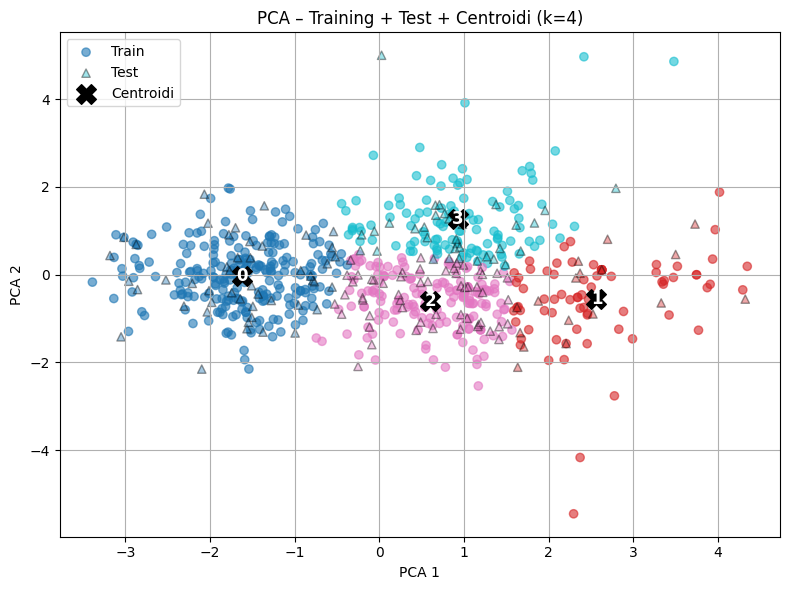

In [9]:
# PCA (solo su training)
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_scaled)
df_train["PCA1"] = X_train_pca[:, 0]
df_train["PCA2"] = X_train_pca[:, 1]
X_test_pca = pca.transform(X_test_scaled)
df_test["PCA1"] = X_test_pca[:, 0]
df_test["PCA2"] = X_test_pca[:, 1]

centroids_pca = pca.transform(kmeans.cluster_centers_)

plt.figure(figsize=(8, 6))

# Punti TRAIN: cerchi pieni
plt.scatter(
    df_train["PCA1"], df_train["PCA2"],
    c=df_train["Cluster"], cmap="tab10",
    marker='o', alpha=0.6, label="Train"
)

# Punti TEST: triangoli
plt.scatter(
    df_test["PCA1"], df_test["PCA2"],
    c=df_test["Cluster"], cmap="tab10",
    marker='^', alpha=0.4, edgecolor='k', label="Test"
)

# Centroidi
plt.scatter(
    centroids_pca[:, 0], centroids_pca[:, 1],
    c="black", marker="X", s=200, label="Centroidi"
)

# Etichette sui centroidi
for i, (x, y) in enumerate(centroids_pca):
    plt.text(x, y, str(i), fontsize=12, ha='center', va='center', color='white', weight='bold')

plt.title(f"PCA – Training + Test + Centroidi (k={K_FINAL})")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

### 8. Visualizzazione del grafico di distribuzioni dei cluster di traning e test set
I grafici riportano la **distribuzione degli archetipi** nei diversi dataset:

- **Training set**: mostra come gli archetipi siano distribuiti nei dati utilizzati per l’addestramento del modello.
- **Test set**: evidenzia la distribuzione negli esempi utilizzati esclusivamente per la valutazione finale.
- **Totale (Train + Test)**: fornisce la visione complessiva dell’intero dataset.

Ogni barra indica il **numero di Pokémon appartenenti a ciascun Archetipo**, mentre l’etichetta sopra la barra riporta la **percentuale corrispondente**.
Questa analisi è utile per verificare l’eventuale presenza di **squilibri tra classi** e per motivare l’uso di tecniche di bilanciamento (es. SMOTE) prima dell’addestramento.

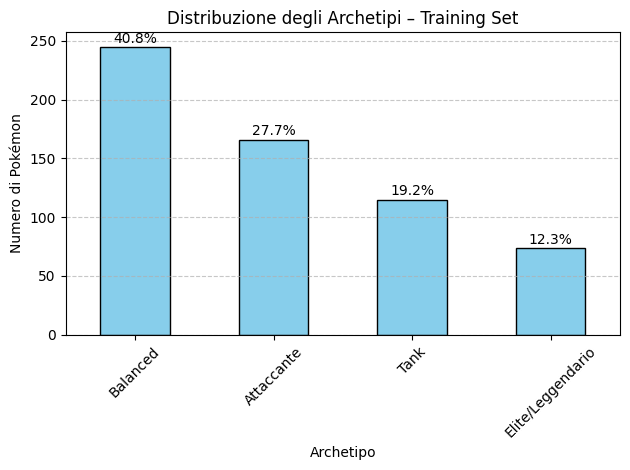

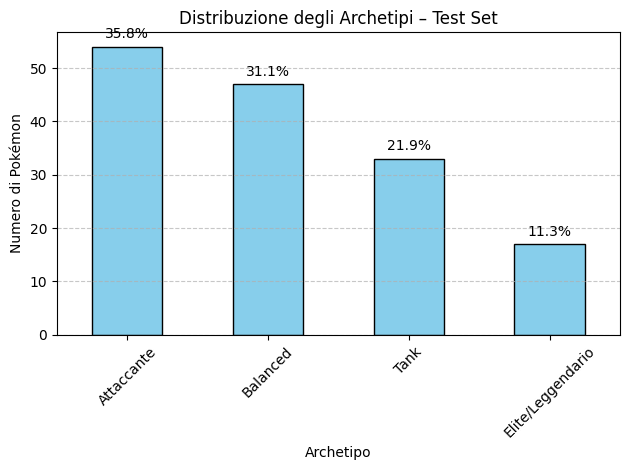

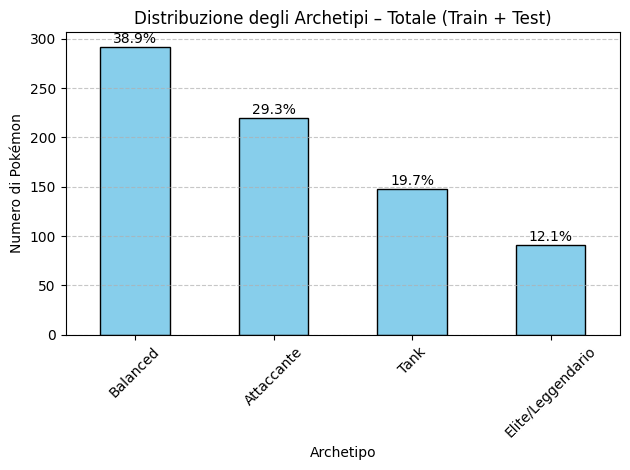

In [10]:
# Funzione per plottare la distribuzione con percentuali
def plot_archetipo_distribution(df, title):
    counts = df['Archetipo'].value_counts()
    total = counts.sum()
    percentuali = (counts / total * 100).round(1)

    ax = counts.plot.bar(rot=45, color='skyblue', edgecolor='black')
    for i, (val, pct) in enumerate(zip(counts, percentuali)):
        ax.text(i, val + 1, f"{pct}%", ha='center', va='bottom', fontsize=10)

    plt.title(title)
    plt.xlabel("Archetipo")
    plt.ylabel("Numero di Pokémon")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Plot singoli
plot_archetipo_distribution(df_train, "Distribuzione degli Archetipi – Training Set")
plot_archetipo_distribution(df_test, "Distribuzione degli Archetipi – Test Set")

# Unione del pd per visualizzare distribuzione totale
df_full = pd.concat([df_train, df_test], ignore_index=True)
plot_archetipo_distribution(df_full, "Distribuzione degli Archetipi – Totale (Train + Test)")

### 9. Applicazione di SMOTE per bilanciare il traning set

In origine, il training set presenta una forte **asimmetria**: archetipi come *Bilanciato* e *Attaccante* sono molto più numerosi rispetto a *Tank* ed *Elite/Leggendario*.
Questa situazione riflette fedelmente il mondo Pokémon, ma può influenzare negativamente i modelli di classificazione, che tenderebbero a favorire le classi più popolose.

Con **SMOTE (Synthetic Minority Oversampling Technique)** vengono generati esempi sintetici per le classi minoritarie, fino a riequilibrare la distribuzione.
Il risultato è un training set **bilanciato**, dove ciascun archetipo ha lo stesso numero di campioni: questo consente ai modelli supervisionati di apprendere in maniera equa e di trattare con la stessa importanza tutte le classi.

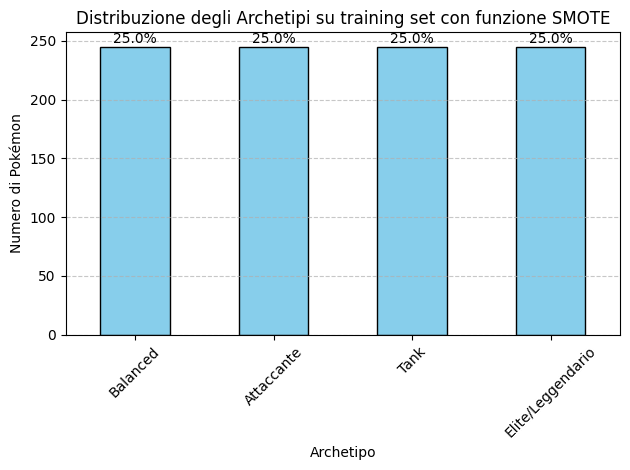

In [11]:
# Prepara i dati per il classificatore supervisionato ---
X_train_sup = df_train[features].values
y_train_sup = df_train["Archetipo"].values

#  Applica SMOTE prima del fit
from imblearn.over_sampling import SMOTE

smote = SMOTE(k_neighbors=5, random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_sup, y_train_sup)

df_train_balanced = pd.DataFrame(X_train_balanced, columns=features)
df_train_balanced["Archetipo"] = y_train_balanced
plot_archetipo_distribution(df_train_balanced, "Distribuzione degli Archetipi su training set con funzione SMOTE")

Il grafico mostra la distribuzione degli archetipi nel **training set dopo l’applicazione di SMOTE**.

### 10. Salvataggio del training set (bilanciato con SMOTE) e del test set

**Nota metodologica.** Il **test set** è stato separato **a monte** dal dataset originale e rimane **comune a tutti i modelli supervisionati che vedremo avanti** per evitare il fenomeno del *data leakage*.
Le sue etichette (Archetipo) sono state ottenute applicando **K-Means sul solo training**, proiettando poi i **centroidi** per assegnare le etichette al test (evitando **data leakage**), e infine **validate** tramite supervisione umana (etichettatura semantica dei cluster).

Poiché, in modo coerente con il dominio Pokémon, la distribuzione degli archetipi nel **training set** risulta **sbilanciata** (ad es. più Bilanciati/Attaccanti e meno Tank/Elite), si è adottata la tecnica **SMOTE** (Synthetic Minority Oversampling Technique) **solo sul training** per **bilanciare le classi**.
Questo consente ai classificatori supervisionati di apprendere decision boundary più equi tra gli archetipi, senza alterare il test.

**Output salvati:**
- `risorse/training_bilanciato.csv` → **solo** feature `OFF_FISICO, OFF_SPECIALE, TANK_FISICO, TANK_SPECIALE` + `Archetipo` (dopo SMOTE).
- `risorse/training_NON_bilanciato.csv` → stesse colonne, **prima** di SMOTE (per confronti).
- `risorse/test_set.csv` → test set “pulito” con `#`, `Name`, le 4 feature e `Archetipo`, invariato (comune a tutti i modelli).

> Tutte le operazioni di bilanciamento, scaling e selezione iperparametri sono state eseguite **esclusivamente sul training**; il test set è stato utilizzato **una sola volta** per la valutazione finale così come da buona prassi metodologica in ambito machine learning.

In [12]:
# Colonne desiderate
features = ["OFF_FISICO", "OFF_SPECIALE", "TANK_FISICO", "TANK_SPECIALE"]
target = "Archetipo"
cols = features + [target]

# Controllo colonne mancanti (così evitiamo il KeyError)
missing_train = [c for c in cols if c not in df_train_balanced.columns]
missing_test  = [c for c in cols if c not in df_test.columns]

if missing_train:
    raise KeyError(f"Train bilanciato: colonne mancanti {missing_train} non trovate in df_train_balanced")
if missing_test:
    raise KeyError(f"Test: colonne mancanti {missing_test} non trovate in df_test")

# Selezione con stesso ordine
train_out = df_train_balanced[cols].copy()
test_out  = df_test[["#","Name"] + cols].copy()
df_train_update = df_train[cols].copy()


# Tipi: le 4 feature devono essere numeriche (evita problemi in fit/predict)
for c in features:
    train_out[c] = pd.to_numeric(train_out[c], errors="coerce")
    test_out[c]  = pd.to_numeric(test_out[c],  errors="coerce")

# (Opzionale) verifica NaN: utile dopo SMOTE/merge
if train_out[features].isna().any().any():
    n = int(train_out[features].isna().sum().sum())
    print(f"Attenzione: {n} NaN nelle feature del train_bilanciato.")
if test_out[features].isna().any().any():
    n = int(test_out[features].isna().sum().sum())
    print(f"Attenzione: {n} NaN nelle feature del test.")

# Salvataggio allineato dei vari file csv
train_out.to_csv("risorse/training_bilanciato.csv", index=False)
df_train_update.to_csv("risorse/training_NON_bilanciato.csv", index=False)

test_out.to_csv("risorse/test_set.csv", index=False)

print("️Salvati: risorse/training_bilanciato.csv e risorse/test.csv (stesse colonne e ordine).")
print("Salvato: risorse/training_bilanciato.csv")

# Distribuzione classi per tutti e 3 i dataset
print("\n=== Distribuzione classi nel TRAIN NON bilanciato ===")
print(pd.Series(df_train_update[target]).value_counts(normalize=True).round(2))
print(pd.Series(df_train_update[target]).value_counts())

print("\n=== Distribuzione classi nel TRAIN bilanciato (SMOTE) ===")
print(pd.Series(df_train_balanced[target]).value_counts(normalize=True).round(2))
print(pd.Series(df_train_balanced[target]).value_counts())

print("\n=== Distribuzione classi nel TEST ===")
print(pd.Series(df_test[target]).value_counts(normalize=True).round(2))
print(pd.Series(df_test[target]).value_counts())

️✔ Salvati: risorse/training_bilanciato.csv e risorse/test.csv (stesse colonne e ordine).
✔ Salvato: risorse/training_bilanciato.csv

=== Distribuzione classi nel TRAIN NON bilanciato ===
Archetipo
Balanced             0.41
Attaccante           0.28
Tank                 0.19
Elite/Leggendario    0.12
Name: proportion, dtype: float64
Archetipo
Balanced             245
Attaccante           166
Tank                 115
Elite/Leggendario     74
Name: count, dtype: int64

=== Distribuzione classi nel TRAIN bilanciato (SMOTE) ===
Archetipo
Balanced             0.25
Attaccante           0.25
Tank                 0.25
Elite/Leggendario    0.25
Name: proportion, dtype: float64
Archetipo
Balanced             245
Attaccante           245
Tank                 245
Elite/Leggendario    245
Name: count, dtype: int64

=== Distribuzione classi nel TEST ===
Archetipo
Attaccante           0.36
Balanced             0.31
Tank                 0.22
Elite/Leggendario    0.11
Name: proportion, dtype: float64
A